In [39]:
import pandas as pd
import numpy as np

# 1. Load and prepare data

# Đọc dữ liệu từ CSV
data = pd.read_csv('./stock_data/BTC_2010-2011.csv')

# Chuyển đổi cột 'Date' sang datetime và đặt làm index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# In ra các cột để kiểm tra
print("Các cột trong dữ liệu:", data.columns)

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Kiểm tra các cột trong dữ liệu
print("Các cột trong dữ liệu:", data.columns)

# Kiểm tra thống kê cơ bản của dữ liệu
print(data.describe())  # Xem thống kê dữ liệu
print("Số lượng giá trị NaN trong mỗi cột:")
print(data.isnull().sum())  # Kiểm tra giá trị NaN
print("Kiểm tra giá trị inf/-inf:")
print(data[data.isin([np.inf, -np.inf]).any(axis=1)])  # Kiểm tra giá trị inf

# Loại bỏ các hàng có giá trị NaN hoặc inf
data = data.dropna()  # Xóa hàng chứa NaN
data = data.replace([np.inf, -np.inf], np.nan).dropna()  # Loại bỏ inf/-inf

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Chuyển đổi scaled_data thành DataFrame để giữ tên cột và index
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Chuyển đổi scaled_data thành DataFrame để giữ tên cột và index
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Số bước thời gian
timesteps = 100

# Tạo X và y
X = []
y = []

# Xác định vị trí của cột 'Close'
close_index = data.columns.get_loc('Close')

for i in range(timesteps, len(scaled_data)):
    # Lấy dữ liệu của các bước thời gian trước đó cho tất cả các đặc trưng
    X.append(scaled_data.iloc[i - timesteps:i].values)
    # Lấy giá trị 'Close' tại thời điểm i làm mục tiêu dự đoán
    y.append(scaled_data.iloc[i, close_index])

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # (samples, timesteps, features)
print("Shape of y:", y.shape)  # (samples,)


Các cột trong dữ liệu: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Các cột trong dữ liệu: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
          Adj Close         Close          High           Low          Open  \
count  34105.000000  34105.000000  34105.000000  34105.000000  34105.000000   
mean   75734.798419  75734.798419  75734.798419  75734.798419  75734.798419   
std     9053.527931   9053.527931   9053.527931   9053.527931   9053.527931   
min    65198.042969  65198.042969  65198.042969  65198.042969  65198.042969   
25%    68153.375000  68153.375000  68153.375000  68153.375000  68153.375000   
50%    72066.203125  72066.203125  72066.203125  72066.203125  72066.203125   
75%    86629.593750  86629.593750  86629.593750  86629.593750  86629.593750   
max    93409.023438  93409.023438  93409.023438  93409.023438  93409.023438   

             Volume  
count  3.410500e+04  
mean   1.745148e+07  
std    1.568273e+0

In [40]:
import numpy as np

# Số bước thời gian
timesteps = 100

# Chuẩn hóa toàn bộ dữ liệu trước khi tạo X và y
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Tạo X và y
X = []
y = []
# for i in range(timesteps, len(data)):
#     X.append(data.iloc[i-timesteps:i, :-1].values)  # Các cột đầu vào
#     y.append(data.iloc[i, 1])  # Giá trị Close của bước tiếp theo

for i in range(timesteps, len(scaled_data)):
    # Lấy dữ liệu từ t-100 đến t
    X.append(scaled_data[i-timesteps:i, :-1])  # Các cột đầu vào
    # Giá trị Close tại thời điểm t+1 làm mục tiêu dự đoán
    y.append(scaled_data[i, 1])  # `1` là vị trí cột Close trong scaled_data
    
# Input (X): Sử dụng dữ liệu từ t-100 đến t để dự đoán giá trị Close tại bước t+1.
# Target (y): Lấy giá trị Close tại thời điểm t+1 làm mục tiêu.     
# LSTM sẽ sử dụng dữ liệu của 100 phút trước đó để dự đoán giá trị của phút tiếp theo.

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # (samples, timesteps, features)
print("Shape of y:", y.shape)  # (samples,)


Shape of X: (34005, 100, 5)
Shape of y: (34005,)


In [41]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (27204, 100, 5) Test size: (6801, 100, 5)


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Khởi tạo mô hình LSTM
model = Sequential()

# Thêm các tầng LSTM
# model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_initializer='glorot_uniform', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.1))

# Tầng đầu ra
model.add(Dense(1))

# Compile mô hình
# model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

print(model.summary())

# print("Kiểm tra NaN trong X_train:", np.any(np.isnan(X_train)))
# print("Kiểm tra NaN trong y_train:", np.any(np.isnan(y_train)))
# print("Kiểm tra inf trong X_train:", np.any(np.isinf(X_train)))
# print("Kiểm tra inf trong y_train:", np.any(np.isinf(y_train)))
# 
# print("Min/Max trong X_train:", np.min(X_train), np.max(X_train))
# print("Min/Max trong y_train:", np.min(y_train), np.max(y_train))
# 
# print("Shape of X_train:", X_train.shape)
# print("Shape of y_train:", y_train.shape)
# 
# print("Kiểm tra thang đo của X_train:")
# print(X_train[0])

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 100, 128)       │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 60s 87ms/step - loss: 0.0371 - mae: 0.0371 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 2/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 59s 86ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0080 - val_mae: 0.0080
Epoch 3/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0074 - val_mae: 0.0074
Epoch 4/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0081 - val_mae: 0.0081
Epoch 5/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0052 - val_mae: 0.0052
Epoch 6/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 59s 86ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0119 - val_mae: 0.0119
Epoch 7/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0047 - val_mae: 0.0047
Epoch 8/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0193 - val_mae: 0.0193
Epoch 9/50
681/681 ━━━━━━━━━━━━━━━━

In [43]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Hiển thị kích thước đầu ra
print("Shape of predictions:", y_pred.shape)


213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Shape of predictions: (6801, 1)


In [44]:
# Chuyển đổi giá trị dự đoán và thực tế về thang đo gốc
y_pred_original = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], data.shape[1] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))), axis=1))[:, 0]

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# mse = mean_squared_error(y_test_original, y_pred_original)
# mae = mean_absolute_error(y_test_original, y_pred_original)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")


MSE: 0.00011871807912975641
MAE: 0.006860700731027453


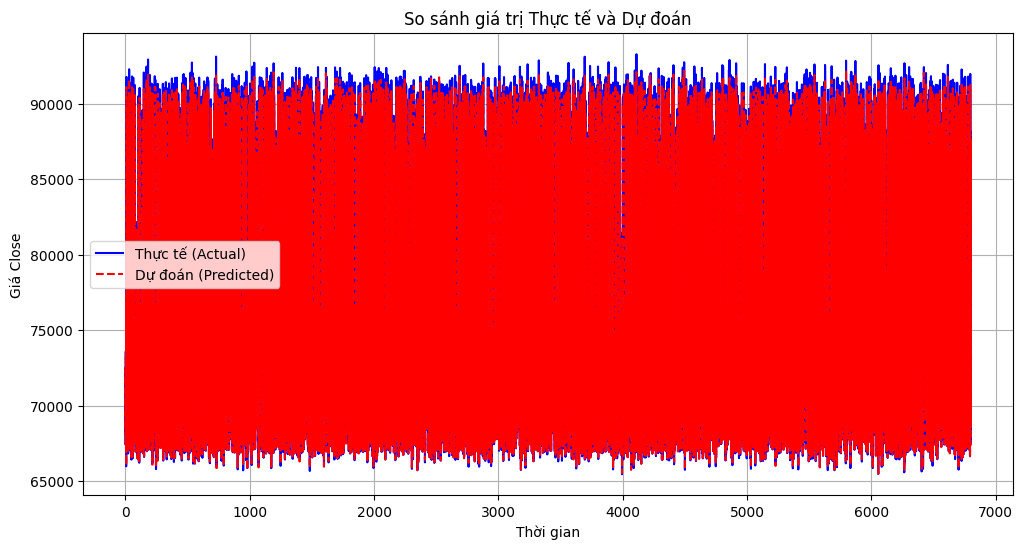

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Thực tế (Actual)", color='blue', linestyle='-')
plt.plot(y_pred_original, label="Dự đoán (Predicted)", color='red', linestyle='--')
plt.title("So sánh giá trị Thực tế và Dự đoán")
plt.xlabel("Thời gian")
plt.ylabel("Giá Close")
plt.legend()
plt.grid(True)
plt.show()


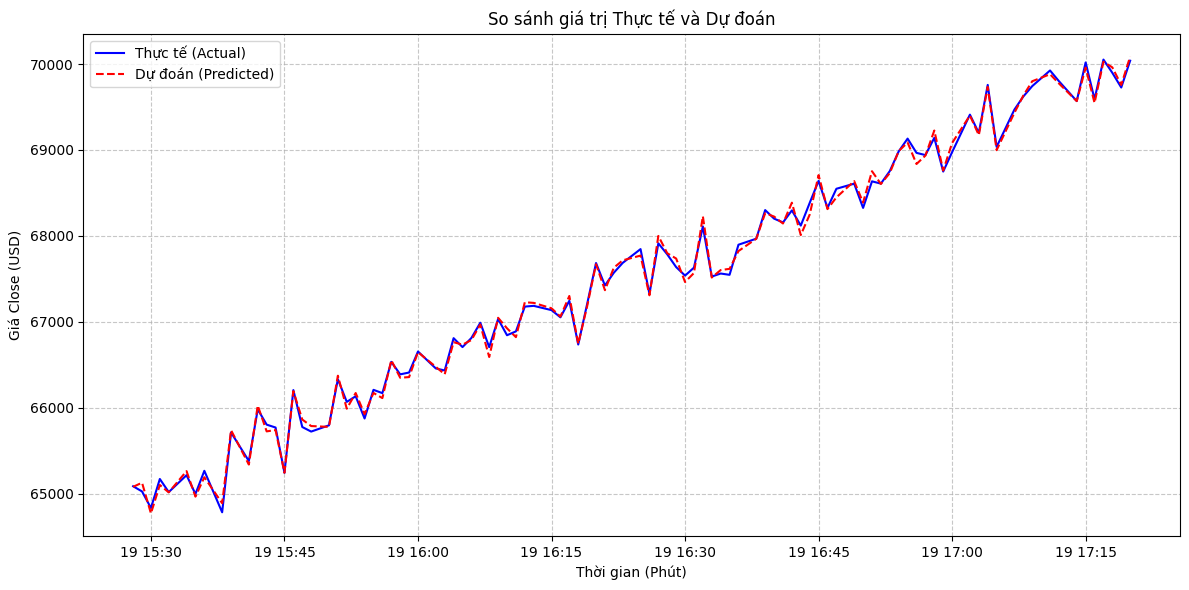

In [48]:
# Giả sử 'data' là DataFrame gốc chứa cột 'Date'
time_index_test = data.index[-len(y_test_original):]  # Lấy thời gian tương ứng với tập test

# Vẽ biểu đồ với trục X là thời gian
plt.figure(figsize=(12, 6))
plt.plot(time_index_test, y_test_original, label="Thực tế (Actual)", color='blue', linestyle='-')
plt.plot(time_index_test, y_pred_original, label="Dự đoán (Predicted)", color='red', linestyle='--')
plt.title("So sánh giá trị Thực tế và Dự đoán")
plt.xlabel("Thời gian (Phút)")
plt.ylabel("Giá Close (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
